In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Concatenate,UpSampling2D,Dropout,Input,GlobalAveragePooling2D,AveragePooling2D,Conv2DTranspose
from tensorflow.keras.metrics import Precision,Recall
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy,Precision , Recall
from sklearn.model_selection import train_test_split
import numpy as np 
import matplotlib.pyplot as plt


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def segnet(input_size):
    """encoder"""
    input_scan = Input(input_size)
    conv1 = Conv2D(32,(3,3),padding="same",activation="relu")(input_scan)
    conv1 = Conv2D(32,(3,3),padding="same",activation="relu")(conv1)
    pool1 = MaxPooling2D((2,2),strides=2)(conv1)
    conv2 = Conv2D(64,(3,3),padding="same",activation="relu")(pool1)
    conv2 = Conv2D(64,(3,3),padding="same",activation="relu")(conv2)
    pool2 = MaxPooling2D((2,2),strides=2)(conv2)
    conv3 = Conv2D(128,(3,3),padding="same",activation="relu")(pool2)
    conv3 = Conv2D(128,(3,3),padding="same",activation="relu")(conv3)
    pool3 = MaxPooling2D((2,2),strides=2)(conv3)
    conv4 = Conv2D(256,(3,3),padding="same",activation="relu")(pool3)
    conv4 = Conv2D(256,(3,3),padding="same",activation="relu")(conv4)
    pool4 = MaxPooling2D((2,2),strides=2)(conv4)
    conv5 = Conv2D(512,(3,3),padding="same",activation="relu")(pool4)
    
    p1 = GlobalAveragePooling2D()(conv5)
    p1 = tf.keras.layers.Reshape((1,1,512))(p1)
    p1 = Conv2D(64,(1,1))(p1)
    p1 = UpSampling2D((256,256))(p1)
    p2 = AveragePooling2D((2,2))(conv5)
    p2 = Conv2D(64,(1,1))(p2)
    p2 = UpSampling2D((16,16))(p2)
    p3 = AveragePooling2D((4,4))(conv5)
    p3 = Conv2D(64,(1,1))(p3)
    p3 = UpSampling2D((32,32))(p3)
    p4 = AveragePooling2D((8,8))(conv5)
    p4 = Conv2D(64,(1,1))(p4)
    p4 = UpSampling2D((64,64))(p4)
    mspool = Concatenate()([conv2,p1,p2,p3,p4])
    print(mspool.shape)
    out = Conv2D(256,3,  padding='same',activation="relu")(mspool)
    out = Conv2D(256,3,  padding='same',activation="relu")(out)
    out = UpSampling2D((2, 2))(out)
    out_layer = Conv2D(1,1,  padding='same',activation="sigmoid")(out)
    model = tf.keras.Model(input_scan,out_layer,name='pspnet')
    return model

In [3]:
model =  segnet((512,512,1))

(None, 256, 256, 320)


In [4]:
model.summary()

Model: "pspnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                            

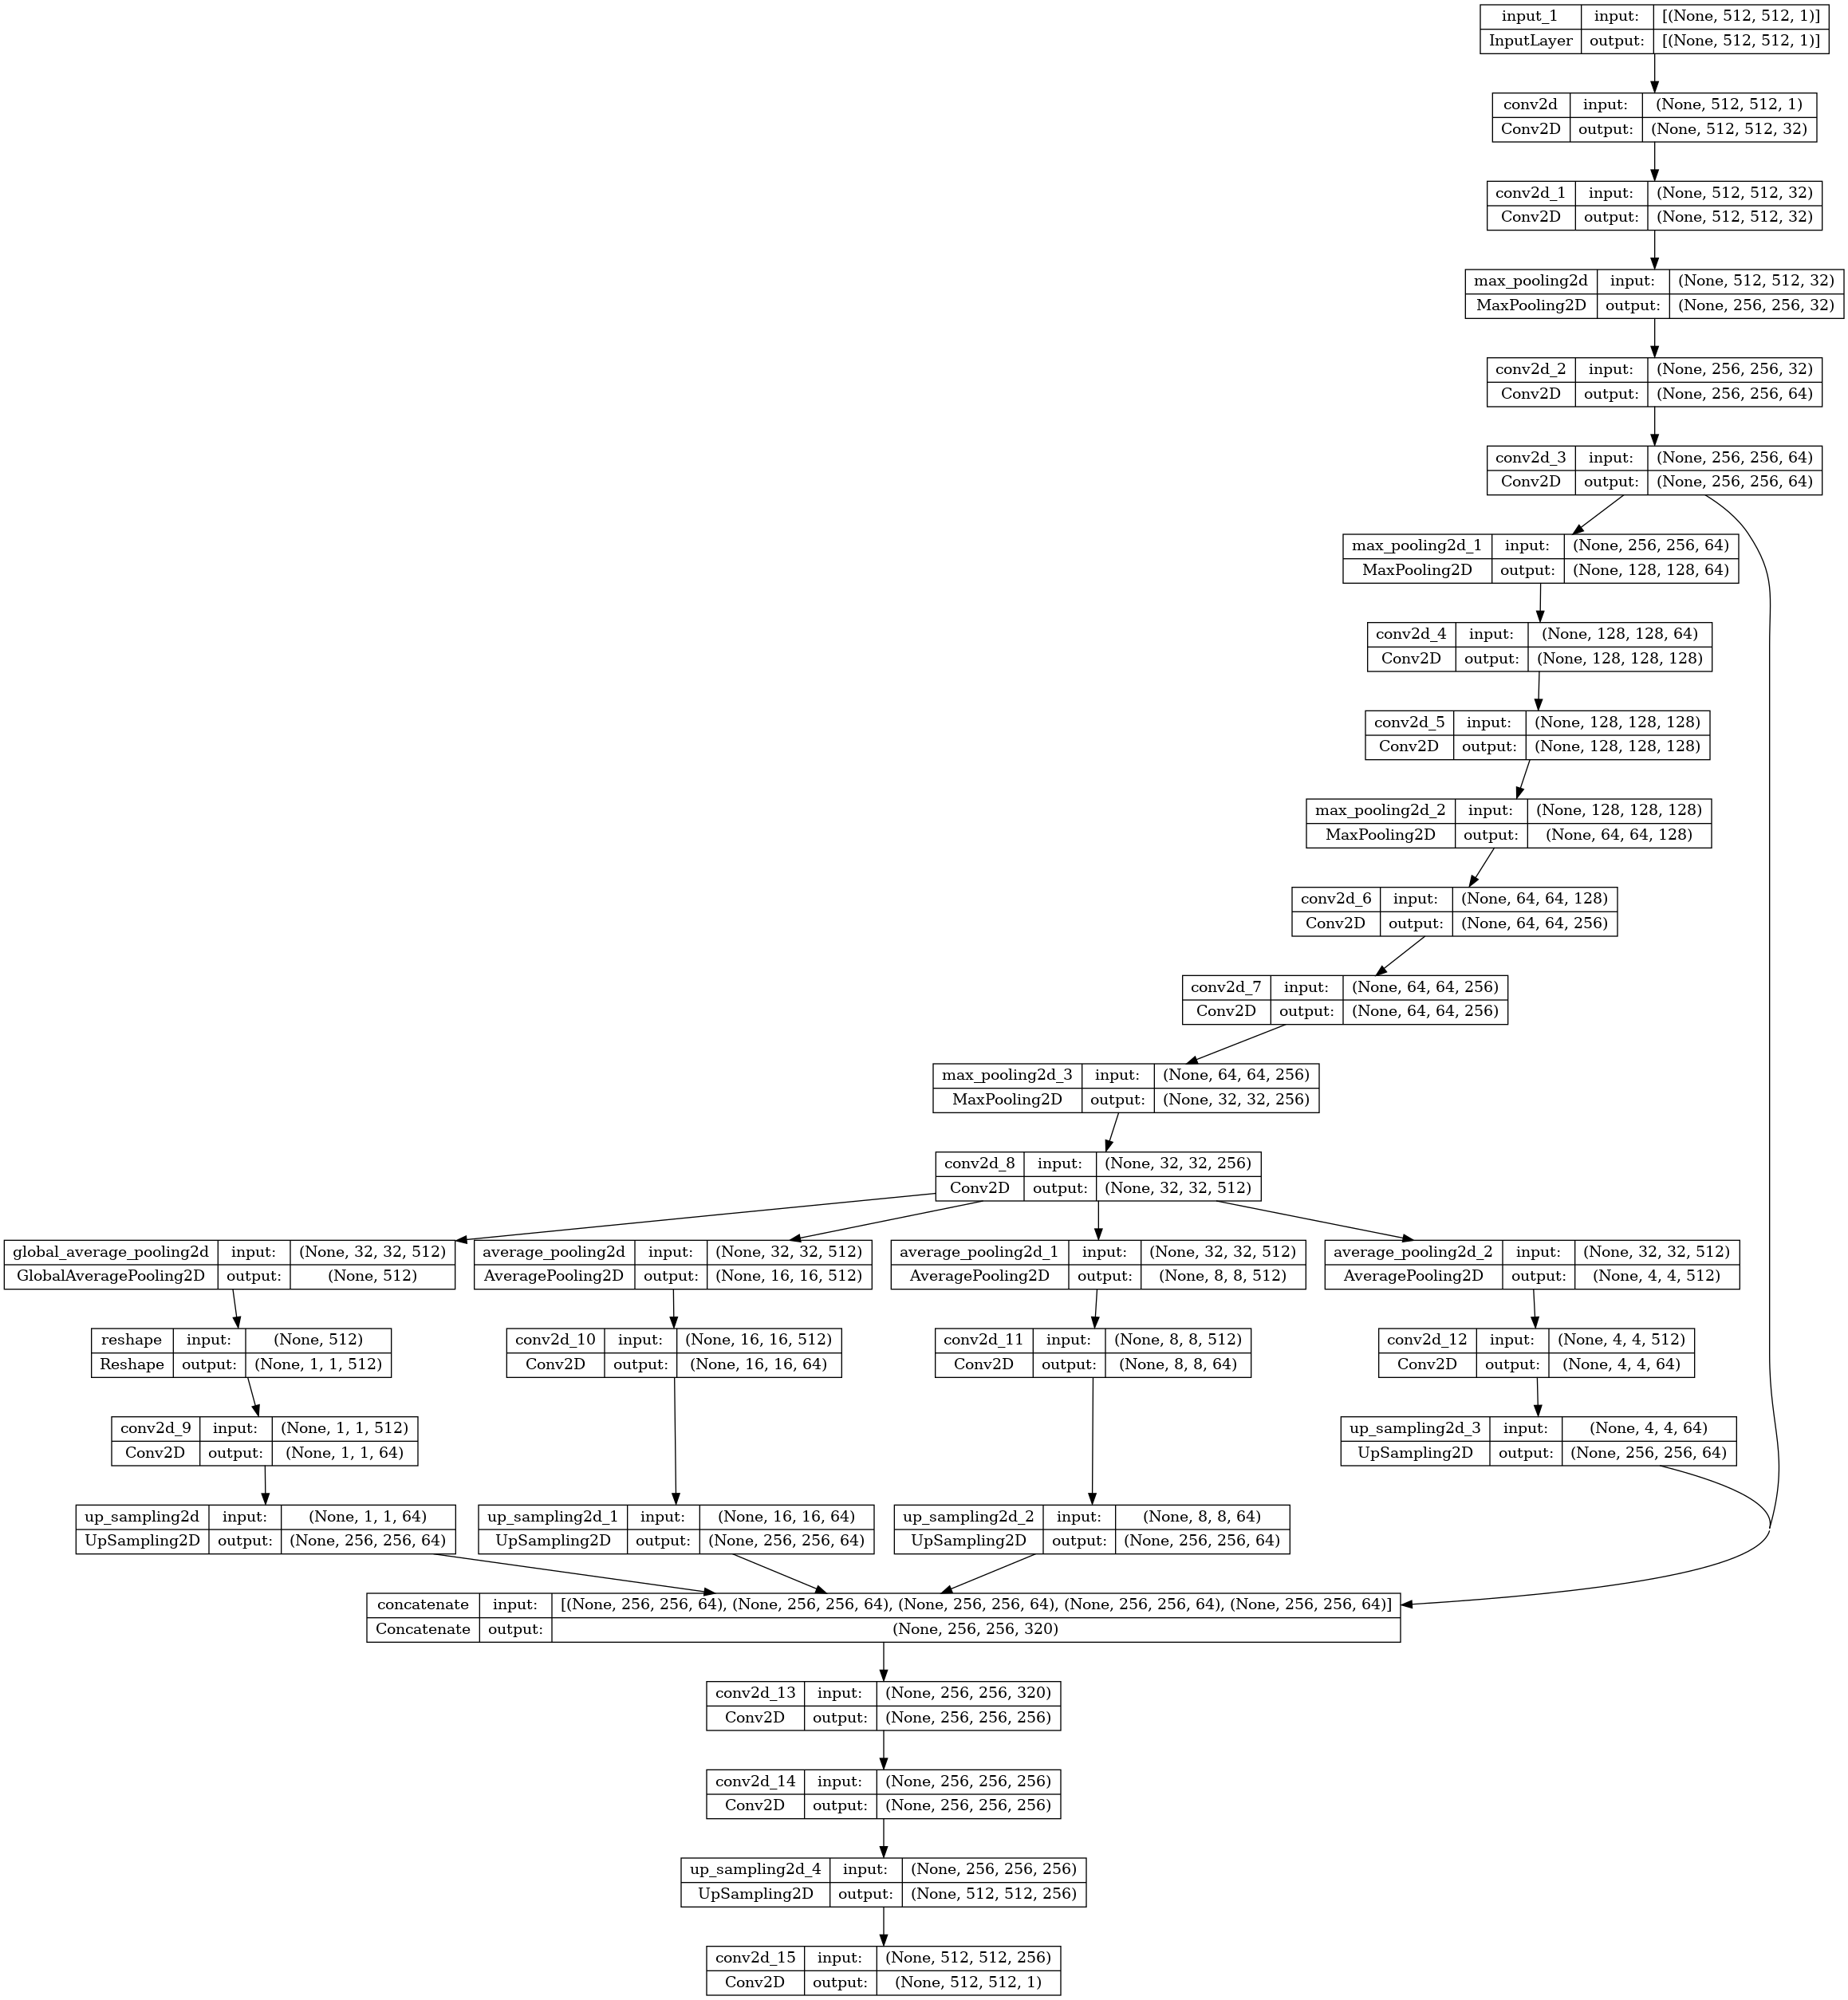

In [5]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, rankdir='TB',
to_file='model_cifar10.png')

In [6]:
X1 = np.load("/kaggle/input/data12/X1.npy")
X0 = np.load("/kaggle/input/data12/X0.npy")
Y1 = np.load("/kaggle/input/data12/mask1.npy")
Y0 = np.load("/kaggle/input/data12/mask0.npy")

In [7]:
X = np.concatenate((X1,X0),axis=0)
Y = np.concatenate((Y1,Y0),axis=0)

In [8]:
X1.shape

(1155, 512, 512, 1)

In [9]:
X = X/255

In [10]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y,test_size =0.1,random_state=48)

In [11]:
X1=0
X0=0
Y1 =0
Y0=0
X=0
Y=0


In [12]:
model.compile(optimizer = Adam(learning_rate=0.0001),loss = "BinaryCrossentropy",metrics=["accuracy",Precision(name="percision"),Recall(name="recall")])

In [13]:
hist = model.fit(Xtrain,Ytrain,epochs=50,batch_size=8,validation_data=(Xtest,Ytest))

Epoch 1/50
163/163 [==============================] - 100s 520ms/step - loss: 0.0397 - accuracy: 0.9944 - percision: 5.2337e-04 - recall: 0.0060 - val_loss: 0.0040 - val_accuracy: 0.9995 - val_percision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
163/163 [==============================] - 81s 495ms/step - loss: 0.0037 - accuracy: 0.9995 - percision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0037 - val_accuracy: 0.9995 - val_percision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
163/163 [==============================] - 83s 511ms/step - loss: 0.0035 - accuracy: 0.9995 - percision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.9995 - val_percision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
163/163 [==============================] - 83s 510ms/step - loss: 0.0033 - accuracy: 0.9995 - percision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.9995 - val_percision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
163/163 [===========

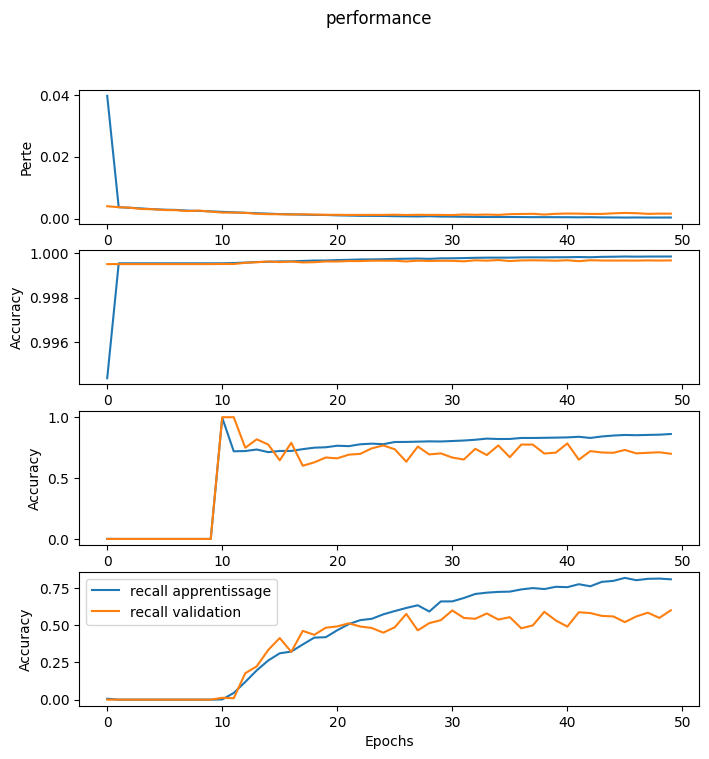

In [14]:
plt.figure(1, figsize=(8, 8))
plt.suptitle("performance") 
plt.subplot(4, 1, 1)
plt.plot(np.arange(0, 50), hist.history["loss"], label="Perte apprentissage")
plt.plot(np.arange(0, 50), hist.history["val_loss"], label="Perte validation")
plt.xlabel("Epochs")
plt.ylabel("Perte") 
plt.subplot(4, 1, 2)
plt.plot(np.arange(0, 50), hist.history["accuracy"], label="Accuracy apprentissage")
plt.plot(np.arange(0, 50), hist.history["val_accuracy"], label="Accuracy validation") 
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")
plt.subplot(4, 1, 3)
plt.plot(np.arange(0, 50), hist.history["percision"], label="percision apprentissage")
plt.plot(np.arange(0, 50), hist.history["val_percision"], label="percision validation") 
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")
plt.subplot(4, 1, 4)
plt.plot(np.arange(0, 50), hist.history["recall"], label="recall apprentissage")
plt.plot(np.arange(0, 50), hist.history["val_recall"], label="recall validation") 
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")

plt.legend()

In [15]:
model.evaluate(Xtest,Ytest,batch_size=8)

19/19 [==============================] - 3s 155ms/step - loss: 0.0016 - accuracy: 0.9997 - percision: 0.6995 - recall: 0.6011


[0.0016049430705606937,
 0.9996787309646606,
 0.6995240449905396,
 0.6010546684265137]

In [16]:

y_1 = model.predict(Xtest[5].reshape((1,512,512, 1)))

1/1 [==============================] - 0s 224ms/step


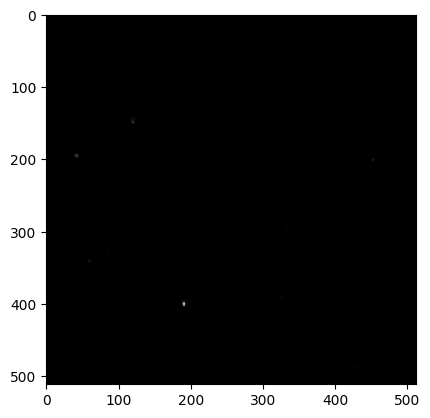

In [17]:
y_1 = y_1.reshape((512,512))
plt.imshow(y_1,cmap="gray")

In [18]:
y_1.max()

0.028224263

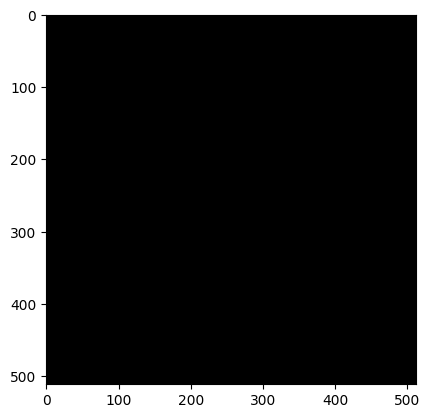

In [19]:
y_1 = np.where(y_1>0.5,1,0)
plt.imshow(y_1,cmap="gray")

In [20]:
norm_img = Xtest[50].reshape((512,512))
img = norm_img * 255

/tmp/ipykernel_23/4290154679.py:6: UserWarning: No contour levels were found within the data range.
  ax2.contour(y_1.reshape((512,512)), levels=[0.4], colors='r', linewidths=2)


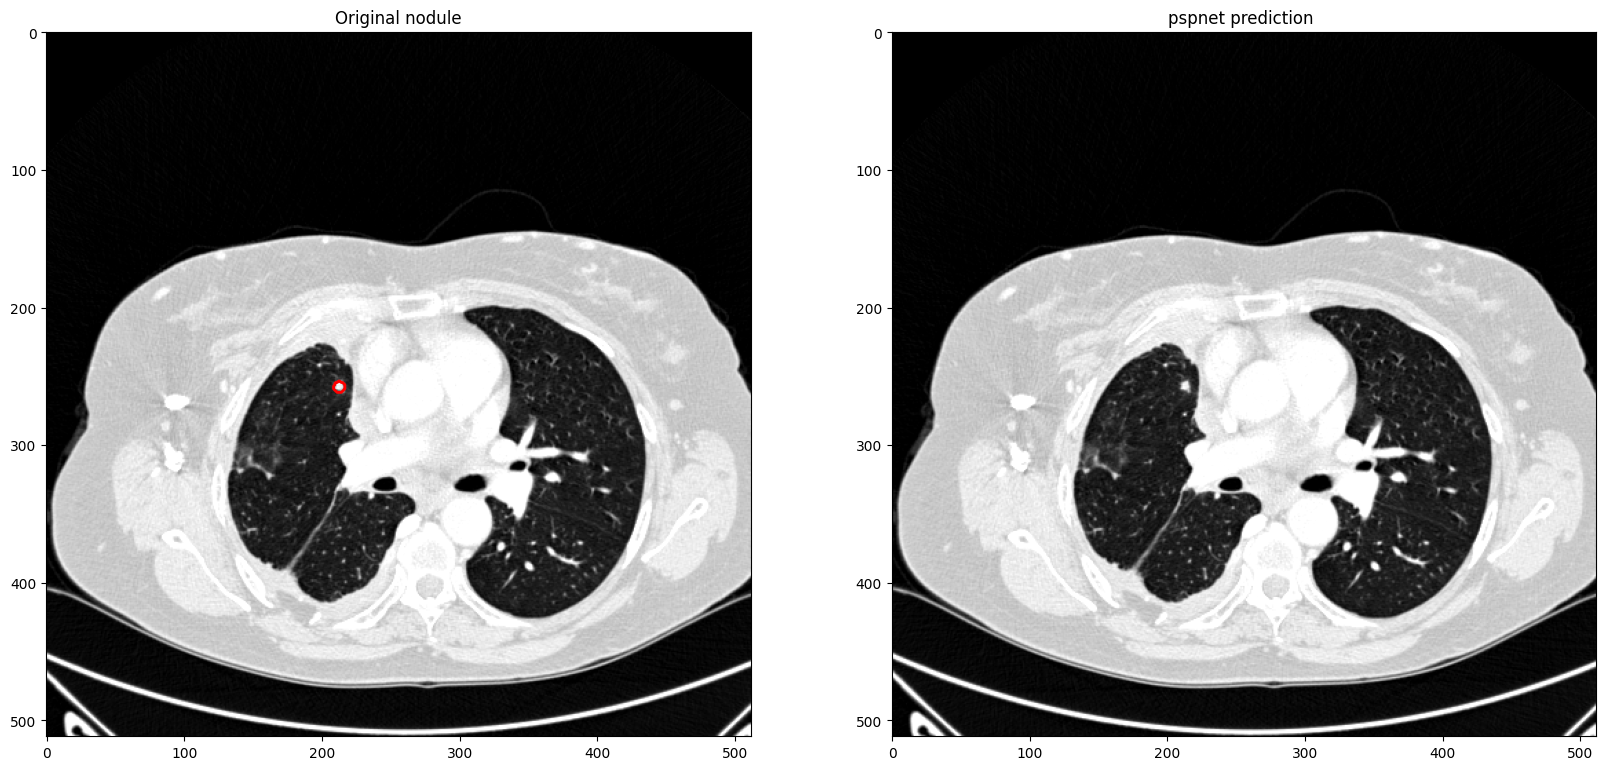

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 20))
ax1.imshow(img,cmap="gray" )
ax1.set_title('Original nodule')
ax2.imshow(img,cmap='gray')
ax2.set_title('pspnet prediction ')
ax2.contour(y_1.reshape((512,512)), levels=[0.4], colors='r', linewidths=2)
ax1.contour(Ytest[50].reshape((512,512)), levels=[0.4], colors='r', linewidths=2)
plt.show()

In [22]:
model.save("pspnet.h5")